In [2]:
import straw
import numpy as np
import struct
import cooler
import myUtils as mu
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from importlib import reload
reload(mu)

<module 'myUtils' from 'myUtils.py'>

In [3]:
res=1000000
cool_handle = cooler.Cooler("normal.iced.mcool" + '::/resolutions/' + str(res))
chrsizes = cool_handle.chromsizes
mat_raw = cool_handle.matrix(sparse=False, balance=False)[:]
np.fill_diagonal(mat_raw, 0)
np.nan_to_num(mat_raw, copy=False)

array([[   0,  525,   89, ...,    8,    8,   19],
       [ 525,    0, 1044, ...,   12,   15,    0],
       [  89, 1044,    0, ...,    7,    7,    0],
       ...,
       [   8,   12,    7, ...,    0,  730,   17],
       [   8,   15,    7, ...,  730,    0,   56],
       [  19,    0,    0, ...,   17,   56,    0]], dtype=int32)

In [45]:
class HiCNorm(object):
    def __init__(self, matrix):
        self.bias = None
        self.matrix = matrix
        self.norm_matrix = None
        self._bias_var = None

    def iterative_correction(self, max_iter=50):
        mat = np.array(self.matrix, dtype=float)  ## use float to avoid int overflow
        # remove low count rows for normalization
        row_sum = np.sum(mat, axis=1)
        low_count = np.quantile(row_sum, 0.15)  # 0.15 gives best correlation between KR/SP/VC
        mask_row = row_sum < low_count
        mat[mask_row, :] = 0
        mat[:, mask_row] = 0
        
        self.bias = np.ones(mat.shape[0])
        self._bias_var = []
        x, y = np.nonzero(mat)
        mat_sum = np.sum(mat)   # force the sum of matrix to stay the same, otherwise ICE may not converge as fast

        for i in range(max_iter):
            bias = np.sum(mat, axis=1)
            bias_mean = np.mean(bias[bias > 0])
            bias_var = np.var(bias[bias > 0])
            self._bias_var.append(bias_var)
            bias = bias / bias_mean
            bias[bias == 0] = 1

            mat[x, y] = mat[x, y] / (bias[x]*bias[y])
            new_sum = np.sum(mat)
            mat = mat * (mat_sum / new_sum)

            # update total bias
            self.bias = self.bias * bias * np.sqrt(new_sum / mat_sum)
        
        self.norm_matrix = np.array(self.matrix, dtype=float)
        self.norm_matrix[x, y] = self.norm_matrix[x, y] / (self.bias[x] * self.bias[y])
        
    def vanilla_coverage(self):
        self.iterative_correction(max_iter=1)

In [5]:
def get_intra_diags(matrix):
    np.nan_to_num(matrix, copy=False)
    ncol = matrix.shape[1]
    return [matrix.diagonal(i) for i in range(ncol)]

def get_intra_diags_mean_variance(matrix):
    diags = get_intra_diags(matrix)
    diags_mean = [np.mean(diags[i]) for i in range(ncol)]
    diags_var = [np.var(diags[i]) for i in range(ncol)]
    return diags_mean, diags_var

def get_inter_mean_variance(matrix, inter_index):
    inter_vec = matrix[inter_index == 1]
    return np.mean(inter_vec), np.var(inter_vec)

In [6]:
def keep_intra_or_inter(mat, chrsizes, keep):
    chrsizes_bins = chrsizes // res + 1
    chrsizes_bins_cum = [0] + list(np.cumsum(chrsizes_bins))
    chrsizes_bins_cum_start = {chrsizes_bins.keys()[i]:chrsizes_bins_cum[i] for i in range(len(chrsizes_bins))}

    mat_keep = np.array(mat, dtype=float)
    inter_index = np.ones(mat.shape, dtype=int)
    intra_index = np.zeros(mat.shape, dtype=int)
    
    for i in range(23):
        start, end = chrsizes_bins_cum[i], chrsizes_bins_cum[i+1]
        if keep == "inter":
            mat_keep[start:end, start:end] = 0
        inter_index[start:end, start:end] = 0

    if keep == "intra":
        mat_keep[inter_index == 1] = 0
    
    intra_index[inter_index == 0] = 1
    inter_index = np.triu(inter_index)
    intra_index = np.triu(intra_index)

    return mat_keep, intra_index, inter_index

def kth_diag_indices(a, k):
    rows, cols = np.diag_indices_from(a)
    if k < 0:
        return rows[-k:], cols[:k]
    elif k > 0:
        return rows[:-k], cols[k:]
    else:
        return rows, cols

In [46]:
mat_ic = HiCNorm(mat_raw)
mat_ic.iterative_correction()
mat_vc = HiCNorm(mat_raw)
mat_vc.vanilla_coverage()

Text(0, 0.5, 'Variance of biases (1e9)')

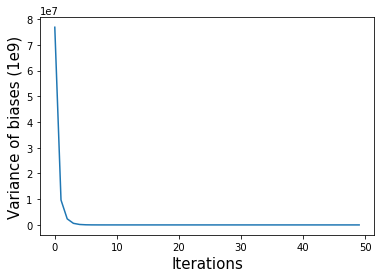

In [47]:
#print(mat_raw_all)
ax = plt.subplot(111)
ax.plot(mat_ic._bias_var)
ax.set_xlabel("Iterations", fontsize=15)
ax.set_ylabel("Variance of biases (1e9)", fontsize=15)
#ax[1].plot(np.log10(a[a>0]))
#ax[1].set_ylim([0,2])
#ax[2].plot(np.log10(b[b>0]))
#ax.set_ylim([5.2, 5.6])
#np.var(a[a>0])

In [ ]:
mat_kr = {}
for chr in [*range(1, 23)] + ['X']:
    res = 1000000
    chr_bins = chrsizes["chr"+str(chr)] // res + 1
    matrix = np.zeros((chr_bins, chr_bins), dtype="float")
    hic_matrix = straw.straw("KR", "test.hg38.hic", str(chr), str(chr), "BP", res)
    x, y = np.array(hic_matrix[0]) // res, np.array(hic_matrix[1]) // res
    matrix[x, y] = hic_matrix[2]
    matrix[y, x] = hic_matrix[2]
    x, y = kth_diag_indices(matrix, 0)
    matrix[x, y] = 0
    mat_kr[chr] = matrix


In [17]:
mat_raw_trans_only, intra, inter = keep_intra_or_inter(mat_raw, chrsizes, "inter")
mat_raw_cis_only, _, _ = keep_intra_or_inter(mat_raw, chrsizes, "intra")

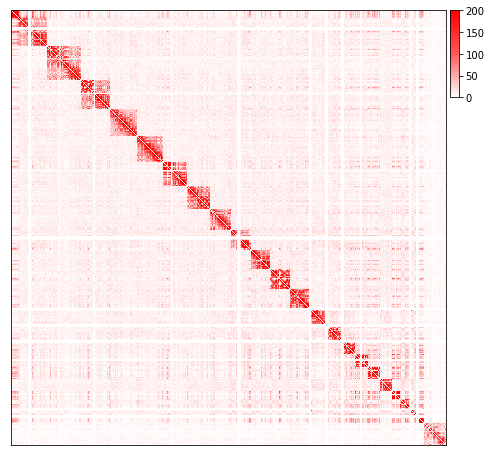

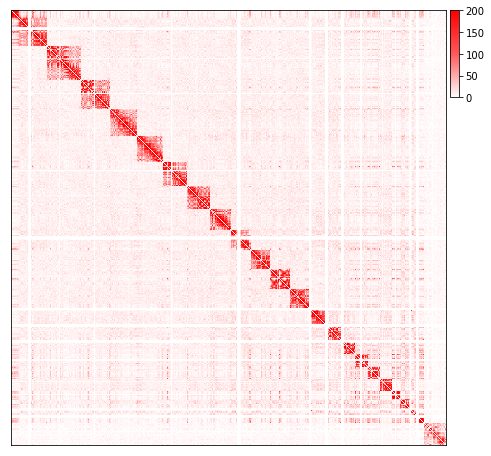

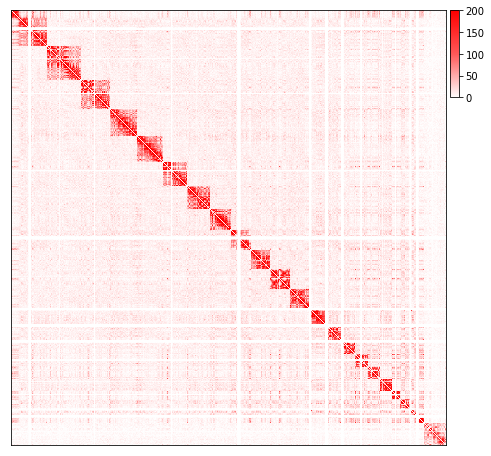

In [48]:
mu.plotMatrix(mat_ic.matrix, vmax=200)
mu.plotMatrix(mat_ic.norm_matrix, vmax=200)
mu.plotMatrix(mat_vc.norm_matrix, vmax=200)

In [15]:
def correlation_by_distance(mat_1, mat_2, intra_index, method="pearson"):
    corr = []
    for dist in range(200):
        row_index, col_index = kth_diag_indices(mat_1, dist)
        diag_1 = [mat_1[x, y] for x, y in zip(row_index, col_index) if intra_index[x, y]]
        diag_2 = [mat_2[x, y] for x, y in zip(row_index, col_index) if intra_index[x, y]]
        if method == "pearson":
            corr.append(np.corrcoef(diag_1, diag_2)[0, 1])
        elif method == "spearman":
            corr.append(spearmanr(diag_1, diag_2)[0])
    return np.array(corr)

def correlation_by_distance_KR(mat_kr, mat, intra_index, method="pearson"):
    corr = []
    for dist in range(200):
        kr_vec = np.diagonal(mat_kr[1], dist)
        for chr in [*range(2, 23)] + ['X']:
            kr_vec = np.concatenate((kr_vec, np.diagonal(mat_kr[chr], dist)))
            
        mask = np.isnan(kr_vec) # nan will cause Pearson correlation to be nan
        row_index, col_index = kth_diag_indices(mat, dist)
        diag = [mat[x, y] for x, y in zip(row_index, col_index) if intra_index[x, y]]
        diag = np.array(diag)
        
        if method == "pearson":
            corr.append(np.corrcoef(kr_vec[~mask], diag[~mask])[0, 1])
        elif method == "spearman":
            corr.append(spearmanr(kr_vec[~mask], diag[~mask])[0])

    return np.array(corr)

In [51]:
cor_kr_ic = correlation_by_distance_KR(mat_kr, mat_ic.norm_matrix, intra)
cor_kr_vc = correlation_by_distance_KR(mat_kr, mat_vc.norm_matrix, intra)
cor_ic_vc = correlation_by_distance(mat_ic.norm_matrix, mat_vc.norm_matrix, intra)
cor_kr_raw = correlation_by_distance_KR(mat_kr, mat_ic.matrix, intra)
cor_ic_raw = correlation_by_distance(mat_ic.norm_matrix, mat_ic.matrix, intra)
cor_vc_raw = correlation_by_distance(mat_vc.norm_matrix, mat_ic.matrix, intra)


In [62]:
cor_kr_ic = correlation_by_distance_KR(mat_kr, mat_ic.norm_matrix, intra, "spearman")
cor_kr_vc = correlation_by_distance_KR(mat_kr, mat_vc.norm_matrix, intra, "spearman")
cor_ic_vc = correlation_by_distance(mat_ic.norm_matrix, mat_vc.norm_matrix, intra, "spearman")
cor_kr_raw = correlation_by_distance_KR(mat_kr, mat_ic.matrix, intra, "spearman")
cor_ic_raw = correlation_by_distance(mat_ic.norm_matrix, mat_ic.matrix, intra, "spearman")
cor_vc_raw = correlation_by_distance(mat_vc.norm_matrix, mat_ic.matrix, intra, "spearman")


In [ ]:
mu.plotMatrix(mat_raw[0:249, 0:249])
mu.plotMatrix(mat_ic.norm_matrix[0:249, 0:249])
mu.plotMatrix(mat_vc.norm_matrix[0:249, 0:249])

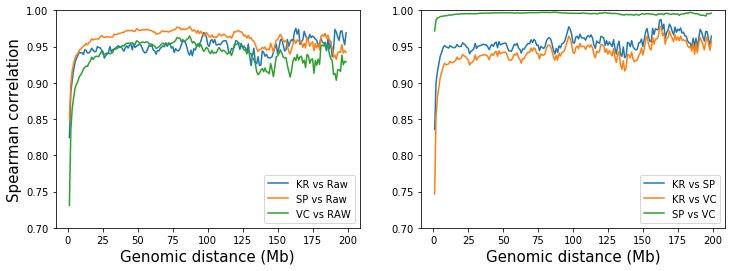

In [75]:
fig, ax = plt.subplots(1,2, figsize=(12, 4))
ax[0].plot(cor_kr_raw)
ax[0].plot(cor_ic_raw)
ax[0].plot(cor_vc_raw)
ax[0].set_ylim([0.7, 1])
ax[0].set_xlabel("Genomic distance (Mb)", fontsize=15)
ax[0].set_ylabel("Spearman correlation", fontsize=15)
ax[0].legend(['KR vs Raw', 'SP vs Raw', 'VC vs RAW'], loc="lower right", fontsize=10)
ax[1].plot(cor_kr_ic)
ax[1].plot(cor_kr_vc)
ax[1].plot(cor_ic_vc)
ax[1].set_ylim([0.7, 1])
ax[1].set_xlabel("Genomic distance (Mb)", fontsize=15)
ax[1].legend(['KR vs SP', 'KR vs VC', 'SP vs VC'], loc="lower right", fontsize=10)

In [65]:
mat_ic_cis_only = HiCNorm(mat_raw_cis_only)
mat_ic_cis_only.iterative_correction()

In [ ]:
mu.plotMatrix(mat_ic.norm_matrix, vmax=450)
#mu.plotMatrix(mat_ic_trans_only.norm_matrix, vmax=450)
mu.plotMatrix(mat_ic_cis_only.norm_matrix, vmax=450)

In [69]:
cor_ic_cis_raw = correlation_by_distance(mat_ic_cis_only.norm_matrix, mat_ic.matrix, intra, "spearman")
cor_ic_cis_ic = correlation_by_distance(mat_ic_cis_only.norm_matrix, mat_ic.norm_matrix, intra, "spearman")

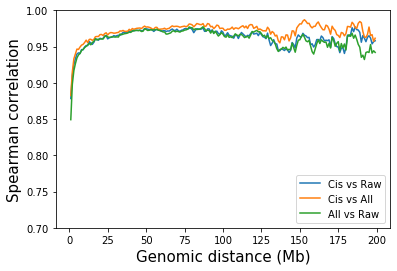

In [74]:
fig, ax = plt.subplots(1,1, figsize=(6, 4))
ax.plot(cor_ic_cis_raw)
ax.plot(cor_ic_cis_ic)
ax.plot(cor_ic_raw)
ax.set_ylim([0.7, 1])
ax.set_xlabel("Genomic distance (Mb)", fontsize=15)
ax.set_ylabel("Spearman correlation", fontsize=15)
ax.legend(['Cis vs Raw', 'Cis vs All', 'All vs Raw'], loc="lower right", fontsize=10)